[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/062_multihead_attention/multihead_attention.ipynb)

# *Abril Johana Berrios Escalera*

# *Multi-head Attention*

En el post anterior implementamos el mecanismo de atención básico del *Transforemer*. Sin embargo, vimos que la capacidad de representación de este mecanismo era limitada. Para resolver este problema, los autores de [*Attention is all you need*](https://arxiv.org/abs/1706.03762) proponen una mejora conocida como *Multi-head attention*.

![](https://github.com/juansensio/blog/blob/master/062_multihead_attention/multiheadattention.png?raw=1)

Este mecanismo toma inspiración en el uso de múltiples filtros en una red convolucional para mejorar la capacidad de representación de datos. En el contexto de atención, esto se traduce en repetir un número determinado de veces (*heads* o cabezas) el mecanismo de *scaled-dot product attention* que conocemos del post anterior. 

$$MultiHead(Q,K,V)= Concat(head_1, ..., head_h) W^o$$

donde

$$ head_i = Attention(QW_q^i, KW_k^i, VW_v^i) $$

A grandes rasgos, repetimos el mecanismo de atención aplicando diferentes proyecciones a la hora de obtener nuestras *queries*, *keys* y *values*. Una vez aplicada la atención a cada cabeza, concatenamos los resultados y aplicamos una nueva capa lineal para obtener el resultado final.

Vamos a ver esta implementación en el mismo ejemplo anterior.

In [23]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Implementación

In [24]:
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader
from scipy.io import loadmat
import torchvision
import pandas as pd
from tensorflow import keras


In [25]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X 
    self.y = y 

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    return torch.tensor(self.X[ix]).float(), torch.tensor(self.y[ix]).long()

class MNISTDataModule(pl.LightningDataModule):

    def __init__(self, batch_size: int = 64, Dataset = Dataset):
        super().__init__()
        self.batch_size = batch_size
        self.Dataset = Dataset

    def setup(self, stage=None):
        (X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
        X_train = X_train.reshape(-1, 3072)
        X_test = X_test.reshape(-1, 3072)
        y_train = y_train.squeeze(1)
        y_test = y_test.squeeze(1)
        X_train, y_train = X_train /255, y_train.astype(np.int)
        X_test, y_test = X_test /255, y_test.astype(np.int)
        #X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., y[:60000].astype(np.int), y[60000:].astype(np.int)
        self.train_ds = self.Dataset(X_train, y_train)
        self.val_ds = self.Dataset(X_test, y_test)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

In [26]:
dm = MNISTDataModule()
dm.setup()
imgs, labels = next(iter(dm.train_dataloader()))
imgs.shape, labels.shape

<ipython-input-25-b98c104dfc85>:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train, y_train = X_train /255, y_train.astype(np.int)
<ipython-input-25-b98c104dfc85>:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

(torch.Size([64, 3072]), torch.Size([64]))

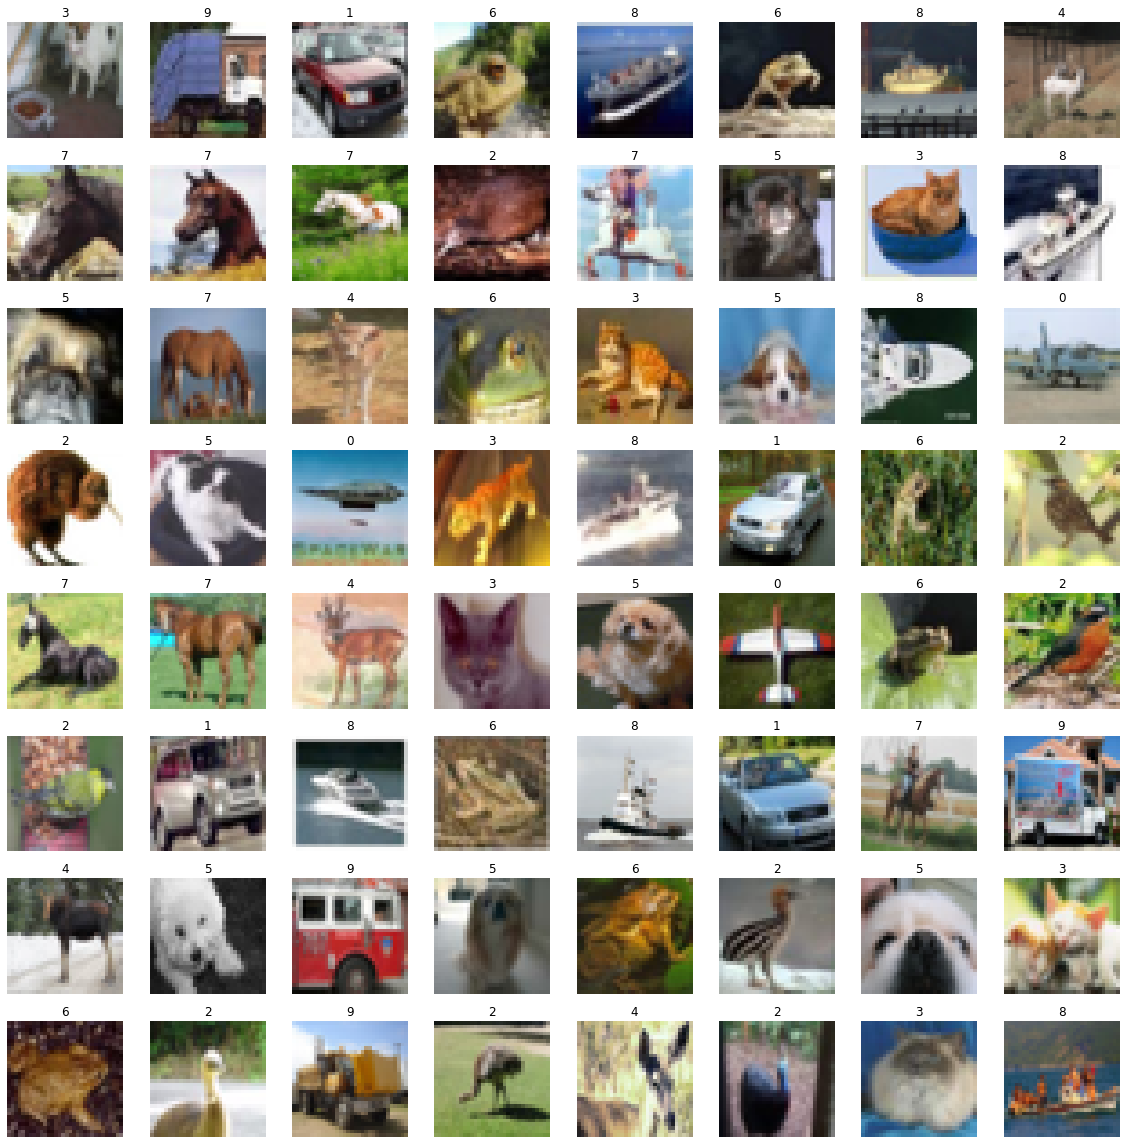

In [27]:
r, c = 8, 8
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(32,32,3), cmap="gray")
        ax.set_title(label.item())
plt.tight_layout()
plt.show()

In [28]:
class MLP(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(3072, 3072),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(3072, 10)
        )

    def forward(self, x):
        return self.mlp(x)

    def predict(self, x):
        with torch.no_grad():
          y_hat = self(x)
          return torch.argmax(y_hat, axis=1)
        
    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('loss', loss)
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.003)
        return optimizer

In [29]:
mlp = MLP()
outuput = mlp(torch.randn(64, 3072))
outuput.shape

torch.Size([64, 10])

In [30]:
mlp = MLP()
trainer = pl.Trainer(max_epochs=5, gpus=1, logger=None)
trainer.fit(mlp, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
<ipython-input-25-b98c104dfc85>:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train, y_train = X_train /255, y_train.astype(np.int)
<ipython-input-25-b98c104dfc85>:26: DeprecationWarning: `np.int` is a deprecated alias for

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Obtenemos una precisión en los datos de validación del 97%, nada impresionante debido a la simplicidad del modelo.

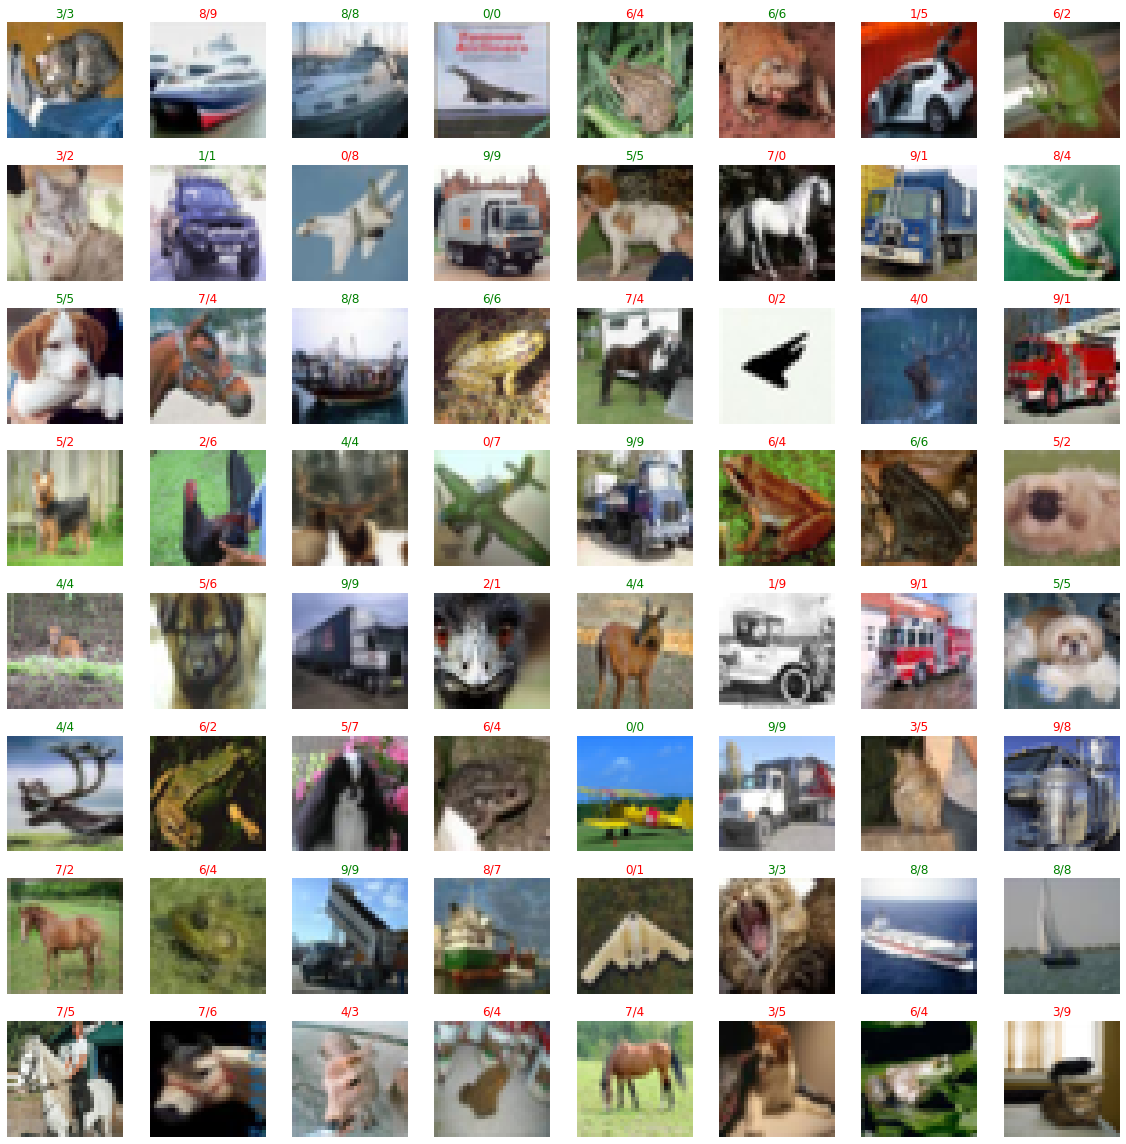

In [31]:
imgs, labels = next(iter(dm.val_dataloader()))
preds = mlp.predict(imgs)

r, c = 8, 8
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(32,32,3), cmap="gray")
        ax.set_title(f'{label.item()}/{preds[ix].item()}', color="green" if label == preds[ix] else 'red')
plt.tight_layout()
plt.show()

Vamos ahora a resolver el mismo problema, utilizando el mecanismo de atención descrito anteriormente. Lo primero que tenemos que tener en cuenta es que los mecanismos de atención funcionan con secuencias, por lo que tenemos que reinterpretar nuestras imágenes. Para ello, vamos a dividirlas en 16 *patches* de 7x7. De esta manera, nuestras imágenes ahora serán secuencias de *patches* con las que nuestro mecanismo de atención podrá trabajar.

In [32]:
class AttnDataset(torch.utils.data.Dataset):
  def __init__(self, X, y, patch_size=(8, 8)):
    self.X = X 
    self.y = y 
    self.patch_size = patch_size

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    image = torch.tensor(self.X[ix]).float().view(32, 32,3) # 28 x 28
    h, w = self.patch_size
    patches = image.unfold(0, h, h).unfold(1, w, w) # 4 x 4 x 8 x 8
    patches = patches.contiguous().view(-1, h*w) # 16 x 64
    return patches, torch.tensor(self.y[ix]).long()

In [33]:
attn_dm = MNISTDataModule(Dataset = AttnDataset) 
attn_dm.setup()
imgs, labels = next(iter(attn_dm.train_dataloader()))
imgs.shape, labels.shape

<ipython-input-25-b98c104dfc85>:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train, y_train = X_train /255, y_train.astype(np.int)
<ipython-input-25-b98c104dfc85>:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

(torch.Size([64, 48, 64]), torch.Size([64]))

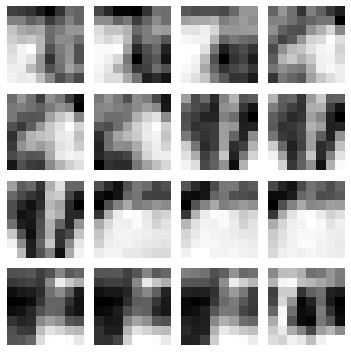

In [34]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(5,5))
for i in range(4):
    for j in range(4):
        ax = plt.subplot(4, 4, i*4 + j + 1)
        ax.imshow(imgs[6,i*4 + j].view(8, 8), cmap="gray")
        ax.axis('off')
plt.tight_layout()
plt.show()

Debido a la baja dimensionalidad de nuestro ejemplo, vamos a repetir nuestro mecanismo de atención básico `n_heads` número de veces. Sin embargo, en la práctica, se divide la dimensión del `embedding` por este número de cabezas. Un detalle importante a tener en cuenta :)

In [35]:
# basado en: https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
import math

class MultiHeadAttention(torch.nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads 
        
        # key, query, value projections
        self.key = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.query = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.value = torch.nn.Linear(n_embd, n_embd*n_heads)
        
        # output projection
        self.proj = torch.nn.Linear(n_embd*n_heads, n_embd)

    def forward(self, x):
        B, L, F = x.size()
        
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        
        # attention (B, nh, L, F) x (B, nh, F, L) -> (B, nh, L, L) 
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, nh, L, L) x (B, nh, L, F) -> (B, nh, L, F)
        y = y.transpose(1, 2).contiguous().view(B, L, F*self.n_heads) # re-assemble all head outputs side by side
        
        return self.proj(y)

class Model(MLP):

    def __init__(self, n_embd=8*8, seq_len=4*4, n_heads=4*4):
        super().__init__()
        self.mlp = None

        self.attn = MultiHeadAttention(n_embd, n_heads)
        self.actn = torch.nn.ReLU(inplace=True)
        self.fc = torch.nn.Linear(n_embd*seq_len*3, 10)

    def forward(self, x):
        x = self.attn(x)
        #print(x.shape)
        y = self.fc(self.actn(x.view(x.size(0), -1)))
        #print(y.shape)
        return y

In [36]:
model = Model()
trainer = pl.Trainer(max_epochs=5, gpus=1, logger=None)
trainer.fit(model, attn_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
<ipython-input-25-b98c104dfc85>:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train, y_train = X_train /255, y_train.astype(np.int)
<ipython-input-25-b98c104dfc85>:26: DeprecationWarning: `np.int` is a deprecated alias for

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Ahora nuestro modelo tiene mayor capacidad de representación (más parámetros) y, por lo tanto, obtenemos resultados mejores.

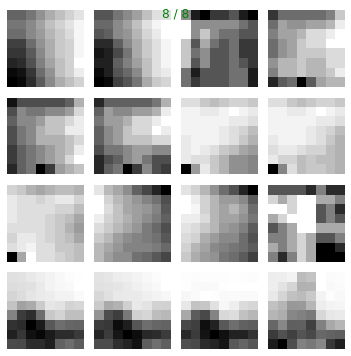

In [37]:
import random

attn_imgs, attn_labels = next(iter(attn_dm.val_dataloader()))
preds = model.predict(attn_imgs)

ix = random.randint(0,attn_dm.batch_size)
fig = plt.figure(figsize=(5,5))
for i in range(4):
    for j in range(4):
        ax = plt.subplot(4, 4, i*4 + j + 1)
        ax.imshow(attn_imgs[ix,i*4 + j].view(8, 8), cmap="gray")
        ax.axis('off')
fig.suptitle(f'{attn_labels[ix]} / {preds[ix].item()}', color="green" if attn_labels[ix] == preds[ix].item() else "red")
plt.tight_layout()
plt.show()

## Resumen

Hemos visto como mejorar el mecanismo de atención añadiendo varias "cabezas" a las cuales atender en paralelo. De esta forma, la capacidad para representar datos de nuestro modelo se ve incrementada. Si bien el mecanismo de *multi-head self attention* es la base del *Transformer*, la capa básica del mismo requiere de un par de detalles extras para funcionar que veremos en el siguiente post.